[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\User\anaconda3\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00         1
        Fake       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Accuracy Score: 1.0


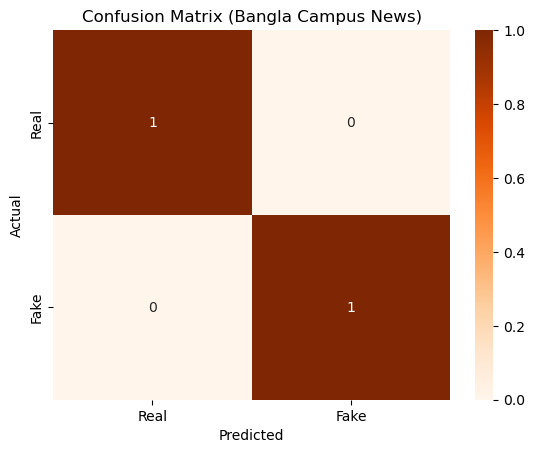

Prediction: সত্য সংবাদ (Real News)
Accuracy Score: 100.00%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModel

nltk.download('punkt')

# Load dataset
df = pd.read_csv('campus_news_bangla.csv')
df['text'] = df['title'] + " " + df['content']

# Clean Bangla text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)

# Bangla stopwords (manual list)
bangla_stopwords = set([...])  # Use your existing list here

def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return ' '.join([word for word in words if word not in bangla_stopwords])

df['final_text'] = df['clean_text'].apply(remove_stopwords)
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Load Bangla BERT
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModel.from_pretrained("sagorsarker/bangla-bert-base")

# Freeze model to avoid training
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# Extract embeddings for all texts
X_embeddings = np.array([get_bert_embedding(text) for text in tqdm(df['final_text'])])
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Bangla Campus News)")
plt.show()


# Prediction function for new news
def predict_news(news_text):
    cleaned = clean_text(news_text)
    cleaned = remove_stopwords(cleaned)
    embedding = get_bert_embedding(cleaned).reshape(1, -1)
    prediction = clf.predict(embedding)[0]
    return "ভুয়া সংবাদ (Fake News)" if prediction == 1 else "সত্য সংবাদ (Real News)"

# Example prediction
new_news = "বিশ্ববিদ্যালয়ে নতুন গবেষণা ল্যাব উদ্বোধন করা হয়েছে।"
print("Prediction:", predict_news(new_news))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")